In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torch.utils.data as data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
from PIL import Image



In [2]:
plt.ion()   # 开启plt的交互模式

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict= pickle.load(fo, encoding='bytes')
        print(dict.keys())
        print(dict['fine_label_names'])
    return dict


class CIFAR100(data.Dataset):
    def __init__(self, name_file, transforms=None):
        super().__init__()
        data_dict = unpickle(name_file)
        data = np.array(data_dict['data'])

        self.data = np.reshape(data,[-1,3,32,32]).transpose([0,2,3,1])
        self.labels = data_dict['fine_labels']
        self.transforms = transforms
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = np.array(img).astype("uint8")
        img_array = Image.fromarray(img)
        if(self.transforms is not None):
            img = self.transforms(img_array)
        return img, label

In [4]:
NUM_TRAIN = 4800

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

def loader_data(class_num):
    cifar100_train = CIFAR100(name_file='../data/' + class_num + '/train', transforms=transform)
    loader_train = torch.utils.data.DataLoader(cifar100_train, batch_size=64,
                                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
    loader_val = torch.utils.data.DataLoader(cifar100_train, batch_size=64,
                                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 5000)))
    cifar100_test = CIFAR100(name_file='../data/' + class_num + '/test', transforms=transform)
    loader_test = torch.utils.data.DataLoader(cifar100_test, batch_size=64,
                                        sampler=sampler.SubsetRandomSampler(range(200)))
    return loader_train, loader_val, loader_test

In [5]:
loader_train, loader_val, loader_test = loader_data('class2')
train_images, train_labels = iter(loader_train).next()
print("train_X:", train_images.size(), "train_y:", train_labels.size())
val_images, val_labels = iter(loader_val).next()
print("val_X:", val_images.size(), "val_y:", val_labels.size())
test_images, test_labels = iter(loader_test).next()
print("test_X:", test_images.size(), "test_y:", test_labels.size())

dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
['orchid', 'poppy', 'rose', 'sunflower', 'bed', 'chair', 'couch', 'table', 'apple', 'mushroom']
dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
['orchid', 'poppy', 'rose', 'sunflower', 'bed', 'chair', 'couch', 'table', 'apple', 'mushroom']
train_X: torch.Size([64, 3, 32, 32]) train_y: torch.Size([64])
val_X: torch.Size([64, 3, 32, 32]) val_y: torch.Size([64])
test_X: torch.Size([64, 3, 32, 32]) test_y: torch.Size([64])


In [6]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device', device)

using device cuda


In [7]:
class Model(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, 
                 channel_3, channel_4, num_classes):
        """
        Default initialization:
        model = Model(in_channel=3, channel_1=96, channel_2=192, 
                 channel_3=192, channel_4=192, num_classes=10)
        """
        super().__init__()
        self.conv1_1 = nn.Conv2d(in_channel, channel_1, 3, padding=1)           #(3, 96, 3)
        self.conv1_2 = nn.Conv2d(channel_1, channel_1, 3, padding=1)            #(96, 96, 3)
        self.conv1_3 = nn.Conv2d(channel_1, channel_1, 3, padding=1, stride=2)  #(96, 96, 3)
        self.conv2_1 = nn.Conv2d(channel_1, channel_2, 3, padding=1)            #(96, 192, 3)
        self.conv2_2 = nn.Conv2d(channel_2, channel_2, 3, padding=1)            #(192, 192, 3)
        self.conv2_3 = nn.Conv2d(channel_2, channel_2, 3, padding=1, stride=2)  #(192, 192, 3)
        self.conv3 = nn.Conv2d(channel_2, channel_3, 3)                         #(192, 192, 3)
        self.conv4 = nn.Conv2d(channel_3, channel_4, 1)                         #(192, 192, 1)
        self.conv5 = nn.Conv2d(channel_4, num_classes, 1)                       #(192, 10, 1)
        
    def forward(self, x):
        """
        x.shape: (64, 3, 32, 32)
        """
        N = x.shape[0]
        x_drop = F.dropout(x, .2)
        conv1_1_out = F.relu(self.conv1_1(x_drop))            # (64, 96, 32, 32)
        conv1_2_out = F.relu(self.conv1_2(conv1_1_out))  # (64, 96, 32, 32)
        layer1_out = F.relu(self.conv1_3(conv1_2_out))  # (64, 96, 32, 32)
        layer1_out_drop = F.dropout(layer1_out, .5)
        conv2_1_out = F.relu(self.conv2_1(layer1_out_drop))   # (64, 192, 16, 16)
        conv2_2_out = F.relu(self.conv2_2(conv2_1_out))   # (64, 192, 16, 16)        
        layer2_out = F.relu(self.conv2_3(conv2_2_out))   # (64, 192, 16, 16)
        layer2_out_drop = F.dropout(layer2_out, .5)  
        layer3_out = F.relu(self.conv3(layer2_out_drop))             # (64, 192, 6, 6)
        layer4_out = F.relu(self.conv4(layer3_out))             # (64, 192, 6, 6)
        layer5_out = F.relu(self.conv5(layer4_out))             # (64, 10, 6, 6)
        out = layer5_out.view(N, 10, -1).mean(dim=2)
        return out

In [8]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [9]:
def plot(x_lst, y_lst, path, name, xlabel, ylabel):
    plt.plot(x_lst, y_lst)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.savefig(path + name)

In [10]:
def train(model, log_file_name, optimizer, scheduler, weight_decay=0.001, epochs=1, best_acc=0.0):
    loss_his = []
    epoch_lst = []
    acc_his = []
    
    best_acc = 0.0
    
    model = model.to(device=device)
    model = nn.DataParallel(model,device_ids=[0,1])  
    
    for e in range(epochs):
        scheduler.step()
        for step, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print('Epoch %d, loss = %.4f' % (e, loss.item()))
        acc = check_accuracy(loader_val, model)
        if acc > best_acc:
            best_acc = acc
            best_model_wts = copy.deepcopy(model.state_dict())
        fo = open(log_file_name, "a")
        fo.write("Epoch: {}\t loss: {:.4f}\t accuracy: {:.2f}\n"\
                 .format(e, loss.item(), acc))
        fo.close()
        print()
        epoch_lst.append(e)
        loss_his.append(loss.item())
        acc_his.append(acc)
    
    return best_model_wts, best_acc, epoch_lst, loss_his, acc_his

In [11]:
def load_pre_model():
    PATH = "../best_model/"
    model_name = "best_model_all_cnn_c.pt"
    model = Model(in_channel=3, channel_1=96, channel_2=192, 
                     channel_3=192, channel_4=192, num_classes=10)
    pretrained_dict = torch.load(PATH + model_name)
    model_dict = {k[7:]: v for k, v in pretrained_dict.items()}
    model_dict['conv5.weight'] = torch.randn(model_dict['conv5.weight'].size())
    model_dict['conv5.bias'] = torch.zeros_like(model_dict['conv5.bias'])
    model.load_state_dict(model_dict)
#     print(model.state_dict)
#     print(model.state_dict())
    return model

In [12]:
lr_lst = [0.0025, 0.001, 0.0005]
log_file_name = "tf_class2.log"
fo = open(log_file_name, "w")
fo.write("Tranfer Learning Trainning log\n")
fo.close()

loss_his_all_lr = []
acc_his_all_lr = []
best_acc_all_lr = 0.0

for learning_rate in lr_lst:
    fo = open(log_file_name, "a")
    fo.write("\nOriginal Learning rate: {}\n".format(learning_rate))
    fo.close()
    print("Learning_rate:", learning_rate)
    model = load_pre_model()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, weight_decay=0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones=[60, 80], gamma=0.1)
    model_wts, acc,  epoch_lst, loss_his, acc_his = train(model, log_file_name, optimizer, scheduler,
                                                          epochs=100, best_acc=0.0)
    if acc > best_acc_all_lr:
        best_acc_all_lr = acc
        best_model_wts = model_wts
        best_lr = learning_rate
    loss_his_all_lr.append(loss_his)
    acc_his_all_lr.append(acc_his)

Learning_rate: 0.0025
Epoch 0, loss = 2.1758
Got 70 / 200 correct (35.00)

Epoch 1, loss = 1.4591
Got 92 / 200 correct (46.00)

Epoch 2, loss = 1.2420
Got 107 / 200 correct (53.50)

Epoch 3, loss = 0.9610
Got 120 / 200 correct (60.00)

Epoch 4, loss = 0.8747
Got 122 / 200 correct (61.00)

Epoch 5, loss = 1.0462
Got 136 / 200 correct (68.00)

Epoch 6, loss = 0.9488
Got 131 / 200 correct (65.50)

Epoch 7, loss = 0.9733
Got 134 / 200 correct (67.00)

Epoch 8, loss = 0.7214
Got 131 / 200 correct (65.50)

Epoch 9, loss = 0.7388
Got 135 / 200 correct (67.50)

Epoch 10, loss = 0.5715
Got 139 / 200 correct (69.50)

Epoch 11, loss = 0.5642
Got 133 / 200 correct (66.50)

Epoch 12, loss = 0.6357
Got 132 / 200 correct (66.00)

Epoch 13, loss = 0.5541
Got 142 / 200 correct (71.00)

Epoch 14, loss = 0.4836
Got 145 / 200 correct (72.50)

Epoch 15, loss = 0.3209
Got 141 / 200 correct (70.50)

Epoch 16, loss = 0.3504
Got 144 / 200 correct (72.00)

Epoch 17, loss = 0.4231
Got 137 / 200 correct (68.50)



Epoch 49, loss = 0.0193
Got 154 / 200 correct (77.00)

Epoch 50, loss = 0.0270
Got 148 / 200 correct (74.00)

Epoch 51, loss = 0.0460
Got 155 / 200 correct (77.50)

Epoch 52, loss = 0.0768
Got 149 / 200 correct (74.50)

Epoch 53, loss = 0.0632
Got 148 / 200 correct (74.00)

Epoch 54, loss = 0.0718
Got 152 / 200 correct (76.00)

Epoch 55, loss = 0.0230
Got 153 / 200 correct (76.50)

Epoch 56, loss = 0.0268
Got 153 / 200 correct (76.50)

Epoch 57, loss = 0.0106
Got 153 / 200 correct (76.50)

Epoch 58, loss = 0.0177
Got 151 / 200 correct (75.50)

Epoch 59, loss = 0.0070
Got 156 / 200 correct (78.00)

Epoch 60, loss = 0.0055
Got 154 / 200 correct (77.00)

Epoch 61, loss = 0.0068
Got 155 / 200 correct (77.50)

Epoch 62, loss = 0.0080
Got 154 / 200 correct (77.00)

Epoch 63, loss = 0.0049
Got 154 / 200 correct (77.00)

Epoch 64, loss = 0.0036
Got 154 / 200 correct (77.00)

Epoch 65, loss = 0.0078
Got 154 / 200 correct (77.00)

Epoch 66, loss = 0.0050
Got 154 / 200 correct (77.00)

Epoch 67, 

Epoch 98, loss = 0.0156
Got 147 / 200 correct (73.50)

Epoch 99, loss = 0.0088
Got 147 / 200 correct (73.50)



In [13]:
print("Best validation accuracy:", best_acc_all_lr)
fo = open(log_file_name, "a")
fo.write("Best validation accuracy: {}".format(best_acc_all_lr))
fo.close()

SAVE_MODEL = 1
PATH = "../best_model/"
model_name = "best_model_tf_class1.pt"
if not os.path.exists(PATH):
    os.mkdir(PATH)
if SAVE_MODEL:
    best_model = load_pre_model()
    best_model_wts = {k[7:]: v for k, v in best_model_wts.items()}
    best_model.load_state_dict(best_model_wts)
    torch.save(best_model.state_dict(), PATH + model_name)

Best validation accuracy: 0.8


In [14]:
best_model.to(device=device)
acc = check_accuracy(loader_test, best_model)
print("Test accuracy:", acc)

Got 153 / 200 correct (76.50)
Test accuracy: 0.765


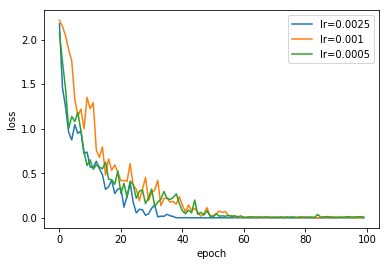

In [15]:
# print(epoch_lst, loss_his_all_lr, acc_his_all_lr)
label_lst = lr_lst
for i in range(len(loss_his_all_lr)):
    plt.plot(epoch_lst, loss_his_all_lr[i], label="lr="+str(label_lst[i]))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

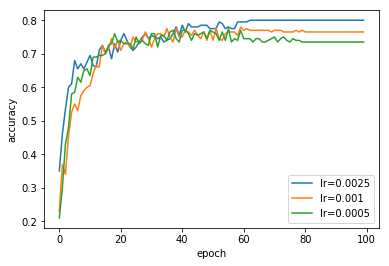

In [16]:
for i in range(len(acc_his_all_lr)):
    plt.plot(epoch_lst, acc_his_all_lr[i], label="lr="+str(label_lst[i]))
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()

In [18]:
lr_lst = [0.0025, 0.001, 0.0005]
log_file_name_sc =  "tf_class2_sc.log"
loss_his_all_lr_sc = []
acc_his_all_lr_sc = []
best_acc_all_sc = 0.0

fo = open(log_file_name_sc, "w")
fo.write("Tranfer Learning Trainning log\n")
fo.close()

for learning_rate in lr_lst:
    print("Learning_rate:", learning_rate)
    model = Model(in_channel=3, channel_1=96, channel_2=192, 
             channel_3=192, channel_4=192, num_classes=10) 
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, weight_decay=0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones=[60, 80], gamma=0.1)
    model_wts, acc,  epoch_lst, loss_his, acc_his = train(model, log_file_name_sc, optimizer, scheduler,
                                                          epochs=100, best_acc=0.0)
    if acc > best_acc_all_sc:
        best_acc_all_sc = acc
        best_model_wts_sc = model_wts
        best_lr_sc = learning_rate
    loss_his_all_lr_sc.append(loss_his)
    acc_his_all_lr_sc.append(acc_his)

Learning_rate: 0.0025
Epoch 0, loss = 2.3001
Got 20 / 200 correct (10.00)

Epoch 1, loss = 2.3027
Got 20 / 200 correct (10.00)

Epoch 2, loss = 2.3006
Got 20 / 200 correct (10.00)

Epoch 3, loss = 2.3026
Got 22 / 200 correct (11.00)

Epoch 4, loss = 2.3032
Got 21 / 200 correct (10.50)

Epoch 5, loss = 2.3032
Got 16 / 200 correct (8.00)

Epoch 6, loss = 2.3010
Got 11 / 200 correct (5.50)

Epoch 7, loss = 2.3044
Got 13 / 200 correct (6.50)

Epoch 8, loss = 2.3008
Got 13 / 200 correct (6.50)

Epoch 9, loss = 2.2969
Got 17 / 200 correct (8.50)

Epoch 10, loss = 2.2969
Got 17 / 200 correct (8.50)

Epoch 11, loss = 2.2974
Got 18 / 200 correct (9.00)

Epoch 12, loss = 2.2921
Got 17 / 200 correct (8.50)

Epoch 13, loss = 2.2640
Got 16 / 200 correct (8.00)

Epoch 14, loss = 2.2554
Got 17 / 200 correct (8.50)

Epoch 15, loss = 2.1918
Got 20 / 200 correct (10.00)

Epoch 16, loss = 2.2186
Got 25 / 200 correct (12.50)

Epoch 17, loss = 2.2959
Got 36 / 200 correct (18.00)

Epoch 18, loss = 1.8676
Go

Epoch 52, loss = 2.3024
Got 18 / 200 correct (9.00)

Epoch 53, loss = 2.3026
Got 18 / 200 correct (9.00)

Epoch 54, loss = 2.3024
Got 25 / 200 correct (12.50)

Epoch 55, loss = 2.3020
Got 18 / 200 correct (9.00)

Epoch 56, loss = 2.3027
Got 27 / 200 correct (13.50)

Epoch 57, loss = 2.3025
Got 29 / 200 correct (14.50)

Epoch 58, loss = 2.3021
Got 18 / 200 correct (9.00)

Epoch 59, loss = 2.3023
Got 18 / 200 correct (9.00)

Epoch 60, loss = 2.3019
Got 18 / 200 correct (9.00)

Epoch 61, loss = 2.3025
Got 18 / 200 correct (9.00)

Epoch 62, loss = 2.3015
Got 18 / 200 correct (9.00)

Epoch 63, loss = 2.3021
Got 18 / 200 correct (9.00)

Epoch 64, loss = 2.3021
Got 18 / 200 correct (9.00)

Epoch 65, loss = 2.3020
Got 18 / 200 correct (9.00)

Epoch 66, loss = 2.3024
Got 18 / 200 correct (9.00)

Epoch 67, loss = 2.3023
Got 18 / 200 correct (9.00)

Epoch 68, loss = 2.3022
Got 19 / 200 correct (9.50)

Epoch 69, loss = 2.3022
Got 18 / 200 correct (9.00)

Epoch 70, loss = 2.3029
Got 19 / 200 correc

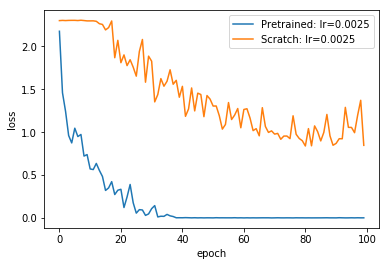

In [20]:
plt.plot(loss_his_all_lr[0], label="Pretrained: lr=0.0025")
plt.plot(loss_his_all_lr_sc[0], label="Scratch: lr=0.0025")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

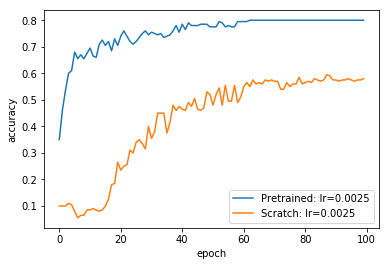

In [21]:
plt.plot(acc_his_all_lr[0], label="Pretrained: lr=0.0025")
plt.plot(acc_his_all_lr_sc[0], label="Scratch: lr=0.0025")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()